In [1]:
import sys, pickle
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from utils import lognormal_gen, generate_matrix
from visualization import *

## Preparations

In [2]:
rng = np.random.default_rng()
RESULT_DIR = 'results/'
AUD_MAP_TYPE, HVC_COND = 'neighbor', 'mature_hvc'
IMG_DIR = 'svg/supplementary/'
# AUD_MAP_TYPE in ('neighbor', 'gaussian', 'discrete')
# HVC_COND in ('mature_hvc', 'developing_hvc')

### Constants

In [3]:
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
tauE, tauI, dt = 30, 10, 1

# EI transfer function parameters
rEmax, rImax, thE, thI, slope = 100, 100, 0, 0, 2

### Read and map auditory inputs

In [4]:
fname = 'realistic_auditory_processing/learned_song_responses.npz'
ma = 1/100 if AUD_MAP_TYPE=='discrete' else None
aud_real, mapping = read_realistic_input(fname, NE, mean=0, scale=2, 
                                         mapping=AUD_MAP_TYPE, mapping_args=ma)

### Constants

In [5]:
# Time window of perturbation
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

gen = lognormal_gen
c = 0.5
# JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.3, 1.8]) / 5
srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
JEE0, JEI0, JIE0, JII0 = np.array([1/srKEc, 1.7/srKIc, 1/srKEc, 1.5/srKIc]) / 10
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1

_ = np.arange(N_rend)
# (N_HVC, N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
save_W_ts = np.round(burst_ts[-1]+KERNEL_WIDTH).astype(int)

w0_mean_HVC2E, w0_std_HVC2E, cW_HVC2E = 1/N_HVC, 1e-2, 1
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05

### Main

In [6]:
T_pre = 100 # time period to keep before song
N_test_rend = 10
T_test = T_burn + T_rend # Total
cases = ('ctrl', 'pert')
res = {k: np.zeros((2,N_test_rend*3,T_pre+T_rend,NE+NI)) for k in cases} 

for l in tqdm(range(3)):
    # Init auditory for training
    aud, _ = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)
    
    # Init HVC
    _ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
    rH = generate_HVC(T, burst_ts, PEAK_RATE+_*0.1, KERNEL_WIDTH+_*0.01)
    
    # Init weights
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True)
    
    # Init models
    net_HVC2E = EINet(NE, NI, N_HVC, w0_mean_HVC2E, (rEmax, thE+6, slope), 
                      (rImax, thI, slope), tauE, tauI, 
                      JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                      w0_std=w0_std_HVC2E, cW=cW_HVC2E)
    net_E2I = EINet(NE, NI, N_HVC, w0_mean_E2E, (rEmax, thE, slope), (rImax, thI, slope), tauE, tauI, 
                    JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                    w0_std=w0_std_E2E, cW=cW_E2E)
    
    hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
    hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
    
    inh_input = np.zeros((T, NI))
    # E_pattern = rng.normal(size=NE, loc=5, scale=1)
    # I_pattern = rng.normal(size=NI, loc=5, scale=1)
    # inh_input[:T_burn] = I_pattern
    # aud[:T_burn] += 5
    
    # Training
    plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-3e-2), 
                             tauW=1e5, asyn_H=10, rE_th=1.5)
    rE_HVC2E, rI, Ws_HVC2E, _, _ = net_HVC2E.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                                 inh_input=inh_input,
                                                 no_progress_bar=True, **plasticity_kwargs)
    
    plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI,JIE=bilin_hebb_IE), 
                             lr=dict(JEI=5e-2,JIE=6e-3), tauW=1e5, 
                             JEI0_mean=JEI0, JIE0_mean=JIE0,
                             asyn_E=10, asyn_I=0, rE_th=1.5, rI_th=5)
    rE_E2I, rI, Ws_E2I, _, _ = net_E2I.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                           inh_input=inh_input,
                                           no_progress_bar=True, **plasticity_kwargs)
    
    # Init auditory for testing
    args = (N_test_rend, T_burn, T_post, None, False)
    aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *args)
    aud_real_pert = aud_real['ctrl'].copy()
    # xi_new = mapping.T @ rng.normal(size=(100,1), scale=2)
    xi_new = rng.normal(size=(NE,1), scale=2)
    for i in range(aud_real_pert.shape[0]):
        t0 = int(aud_real['pert_t0'][i]) + T_pre
        aud_real_pert[i,:,t0:t0+50] = xi_new
    aud_pert, aud_pert_idx = generate_realistic_aud(aud_real_pert, *args)

    # testing
    for k, a in zip(cases, (aud_ctrl, aud_pert)):
        for i in range(a.shape[0]): # for each case, enumerate over songs
            args = dict(rH=rH[:T_test], aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                        noise_strength=1, no_progress_bar=True, inh_input=inh_input[:T_test])
            res[k][0][l*N_test_rend+i] = np.hstack(net_HVC2E.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
            res[k][1][l*N_test_rend+i] = np.hstack(net_E2I.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|█████████████████████████████████████████████| 3/3 [02:40<00:00, 53.46s/it]


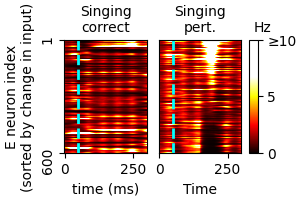

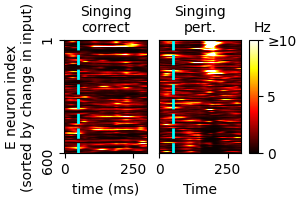

In [7]:
i = 0
titles = ['Singing\ncorrect', 'Singing\npert.']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('HVC2E', 'E2I')):
    _ = [res[k][l][-1,:,:NE] for k in ('ctrl', 'pert')]
    t0 = int(aud_real['pert_t0'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t0+50].mean(axis=1)
    err = [bos_ctrl - syl, np.squeeze(xi_new) - syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t0+250, figsize=(3, 2), 
                                       plot_z=False, sort_by='e', th=10, tpre=50) 
    # for j in range(len(ax)-1):
    #     ax[j].set(xticks=[100, 150], xticklabels=[0, 50], xlabel='')
    ax[0].set(xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'subsyl_err_response_%s.svg' % m))

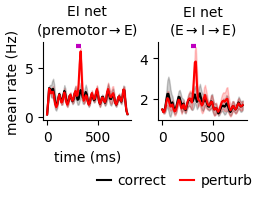

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 2))
ls = ['EI net\n(premotor$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
ts = np.arange(0, T_song, 10)
for i, k in enumerate(ls):
    for j, c in zip(('ctrl', 'pert'), ('k', 'r')):
        aux = res[j][i][:,T_pre:-T_post:10,:NE].mean(axis=-1) 
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, xs=ts)
    ax[i].set_rasterization_zorder(1.4)
    ax[i].set(title=k)
m = aud_real['pert_t0'].mean() + T_pre
for i in range(2):
    ax[i].hlines(ax[i].get_ylim()[1]-0.1, m, m+50, lw=3, color='m')
ax[0].set(xlabel='time (ms)\n\n', ylabel='mean rate (Hz)')
for k, c in zip(('correct', 'perturb'), ('k', 'r')):
    ax[0].plot(0,0, c=c, label=k)
fig.legend(ncols=2, loc=(0.35, 0.04), labelspacing=0.5)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_learn_real_mean_rates.svg'))

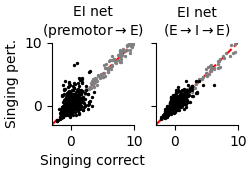

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 2), sharex='all', sharey='all')
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song + T_post
for i in range(2): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    m, s = z_ctrl[:NE].mean(), z_ctrl[:NE].std()
    z_ctrl = (z_ctrl - m) / s
    z_pert = res['pert'][i][:,t0:t1].mean(axis=(0,1))
    z_pert = (z_pert - m) / s
    ax[i].scatter(z_ctrl[NE:], z_pert[NE:], s=8, c='grey', zorder=-2)
    ax[i].scatter(z_ctrl[:NE], z_pert[:NE], s=8, c='k', zorder=-1)
    # ax[j,i].hist2d(z_ctrl[:NE], z_pert[:NE], bins=20, norm='log', 
    #                cmap='binary', range=((0,20),(0,20)));
    ax[i].plot([-3, 50], [-3,50], c='r', ls='--', zorder=-3)
    ax[i].set_rasterization_zorder(0)
    ax[i].set(aspect=1, ylim=[-3,10], xlim=[-3,10])
        
ax[0].set(xlabel='Singing correct')
ax[0].set_ylabel('Singing pert.')
ax[0].set_title('EI net\n(premotor$\\to$E)', fontsize=10)
ax[1].set_title('EI net\n(E$\\to$I$\\to$E)', fontsize=10)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_learn_real_joint_dist.svg'), dpi=300)

5.4079516051573613e-11
0.0025167197149537275


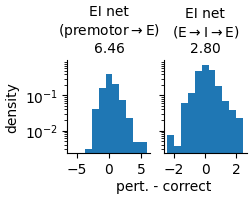

In [35]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, 2, figsize=(2.5, 2), sharey='all')
ls = ['EI net\n(premotor$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i, l in enumerate(ls): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    z_pert = res['pert'][i][:,t0:t1].mean(axis=(0,1))
    m, s = z_ctrl[:NE].mean(), z_ctrl[:NE].std()
    z_ctrl = (z_ctrl - m) / s
    z_pert = (z_pert - m) / s
    diff = z_pert - z_ctrl
    diff = diff[:NE]
    test = skewtest(diff, alternative='greater')
    pval = test.pvalue
    print(pval)
    m = max(-diff.max(), diff.max(), 1)
    ax[i].hist(diff, bins=11, range=(-m, m), density=True)
    ax[i].set(xticks=[-int(m), 0, int(m)])
    ax[i].set_title(l + '\n%.2f' % test.statistic)
ax[0].set(xlabel=' ', ylabel='density', yscale='log')
fig.text(0.65, 0.05, 'pert. - correct', ha='center')
fig.savefig(os.path.join(IMG_DIR, 'subsyl_pert_diff_models.svg'))

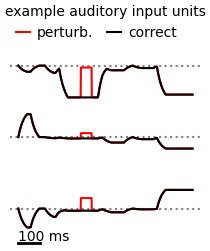

In [15]:
fig, ax = plt.subplots(3, figsize=(2, 2.5), sharex='all', sharey='all')
idx = np.sort(rng.integers(0, NE, size=3))
for i, j in enumerate(idx):
    ax[i].axhline(0, ls=':', c='grey')
    ax[i].plot(aud_real_pert[0,j], c='r', label='perturb.' if i == 0 else '')
    ax[i].plot(aud_real['ctrl'][0,j], c='k', label='correct' if i == 0 else '')
    ax[i].set_axis_off()
ax[0].set(title='example auditory input units\n')
y = ax[-1].get_ylim()[0]
ax[-1].plot([0, 100], [y, y], c='k', lw=2)
ax[-1].text(0, y, '100 ms', va='bottom')
fig.legend(loc=(0.05, 0.82), ncols=2)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_pert_input.svg'))